# Trộn 2 bộ Train SemEval (Laptop + Restaurant)

Parse file XML và tạo DataFrame với định dạng giống `df_train_all.csv`:
- `domain`: laptop hoặc restaurant
- `review_id`: ID của review
- `sentence_id`: ID của câu
- `text`: Nội dung câu
- `aspect`: Category (aspect term)
- `polarity`: positive/negative/neutral
- `label`: 0 (negative), 1 (neutral), 2 (positive)

In [11]:
import pandas as pd
import xml.etree.ElementTree as ET
from pathlib import Path

def parse_semeval_xml(xml_path, domain):
    """
    Parse file XML SemEval và trả về list các dòng dữ liệu
    
    Args:
        xml_path: Đường dẫn file XML
        domain: 'laptop' hoặc 'restaurant'
    
    Returns:
        List of dict với các cột: domain, review_id, sentence_id, text, aspect, polarity, label
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    data = []
    polarity_to_label = {'negative': 0, 'neutral': 1, 'positive': 2}
    
    for review in root.findall('.//Review'):
        review_id = review.get('rid')
        
        for sentence in review.findall('.//sentence'):
            # Bỏ qua các câu OutOfScope
            if sentence.get('OutOfScope') == 'TRUE':
                continue
                
            sentence_id = sentence.get('id')
            text_elem = sentence.find('text')
            
            if text_elem is None or text_elem.text is None:
                continue
                
            text = text_elem.text.strip()
            
            # Lấy tất cả opinions trong câu
            opinions = sentence.findall('.//Opinion')
            
            # Chỉ lấy các câu có opinions
            if opinions:
                for opinion in opinions:
                    category = opinion.get('category')
                    polarity = opinion.get('polarity')
                    
                    if category and polarity:
                        label = polarity_to_label.get(polarity, -1)
                        
                        data.append({
                            'domain': domain,
                            'review_id': review_id,
                            'sentence_id': sentence_id,
                            'text': text,
                            'aspect': category,
                            'polarity': polarity,
                            'label': label
                        })
    
    return data

print("✓ Hàm parse_semeval_xml đã được định nghĩa")

✓ Hàm parse_semeval_xml đã được định nghĩa


In [23]:
# Đường dẫn đến các file XML
LAPTOP_XML = 'h:/SentimentAnalystSchool/MidtermExam/Semeval/Filexml/ABSA16_Laptops_Train_SB1_v2.xml'
RESTAURANT_XML = 'h:/SentimentAnalystSchool/MidtermExam/Semeval/Filexml/ABSA16_Restaurants_Train_SB1_v2.xml'

# Parse file Laptop
print("=" * 60)
print("PARSING LAPTOP DATASET")
print("=" * 60)
laptop_data = parse_semeval_xml(LAPTOP_XML, 'laptop')
print(f"✓ Đã parse {len(laptop_data):,} mẫu từ Laptop dataset")

# Parse file Restaurant
print("\n" + "=" * 60)
print("PARSING RESTAURANT DATASET")
print("=" * 60)
restaurant_data = parse_semeval_xml(RESTAURANT_XML, 'restaurant')
print(f"✓ Đã parse {len(restaurant_data):,} mẫu từ Restaurant dataset")

# ============================================
# THỐNG KÊ LABEL TRƯỚC KHI TRỘN
# ============================================
print("\n" + "=" * 60)
print("📊 THỐNG KÊ LABEL TRƯỚC KHI TRỘN")
print("=" * 60)

# Đếm label cho Laptop
laptop_df = pd.DataFrame(laptop_data)
print("\n🔹 LAPTOP DATASET:")
print(f"   Tổng số mẫu: {len(laptop_df):,}")
print("\n   Phân bố theo Polarity:")
laptop_polarity = laptop_df['polarity'].value_counts()
for polarity, count in laptop_polarity.items():
    pct = count / len(laptop_df) * 100
    print(f"   • {polarity}: {count:,} ({pct:.1f}%)")

# Đếm label cho Restaurant
restaurant_df = pd.DataFrame(restaurant_data)
print("\n🔹 RESTAURANT DATASET:")
print(f"   Tổng số mẫu: {len(restaurant_df):,}")
print("\n   Phân bố theo Polarity:")
restaurant_polarity = restaurant_df['polarity'].value_counts()
for polarity, count in restaurant_polarity.items():
    pct = count / len(restaurant_df) * 100
    print(f"   • {polarity}: {count:,} ({pct:.1f}%)")

# So sánh song song
print("\n" + "=" * 60)
print("📊 SO SÁNH SONG SONG")
print("=" * 60)
print(f"\n{'Polarity':<12} {'Laptop':>10} {'Restaurant':>12} {'Tổng':>10}")
print("-" * 46)
for polarity in ['positive', 'negative', 'neutral']:
    laptop_count = laptop_polarity.get(polarity, 0)
    restaurant_count = restaurant_polarity.get(polarity, 0)
    total = laptop_count + restaurant_count
    print(f"{polarity:<12} {laptop_count:>10,} {restaurant_count:>12,} {total:>10,}")
print("-" * 46)
print(f"{'TỔNG':<12} {len(laptop_df):>10,} {len(restaurant_df):>12,} {len(laptop_df) + len(restaurant_df):>10,}")

PARSING LAPTOP DATASET
✓ Đã parse 2,909 mẫu từ Laptop dataset

PARSING RESTAURANT DATASET
✓ Đã parse 2,507 mẫu từ Restaurant dataset

📊 THỐNG KÊ LABEL TRƯỚC KHI TRỘN

🔹 LAPTOP DATASET:
   Tổng số mẫu: 2,909

   Phân bố theo Polarity:
   • positive: 1,637 (56.3%)
   • negative: 1,084 (37.3%)
   • neutral: 188 (6.5%)

🔹 RESTAURANT DATASET:
   Tổng số mẫu: 2,507

   Phân bố theo Polarity:
   • positive: 1,657 (66.1%)
   • negative: 749 (29.9%)
   • neutral: 101 (4.0%)

📊 SO SÁNH SONG SONG

Polarity         Laptop   Restaurant       Tổng
----------------------------------------------
positive          1,637        1,657      3,294
negative          1,084          749      1,833
neutral             188          101        289
----------------------------------------------
TỔNG              2,909        2,507      5,416


PARSING TEST DATASETS
✓ Laptop Test: 801 mẫu
✓ Restaurant Test: 859 mẫu

📊 THỐNG KÊ CHI TIẾT CẢ 4 BỘ DỮ LIỆU

Dataset                Positive   Negative    Neutral      Total
--------------------------------------------------------------
Laptop Train              1,637      1,084        188      2,909
Restaurant Train          1,657        749        101      2,507
Laptop Test                 481        274         46        801
Restaurant Test             611        204         44        859


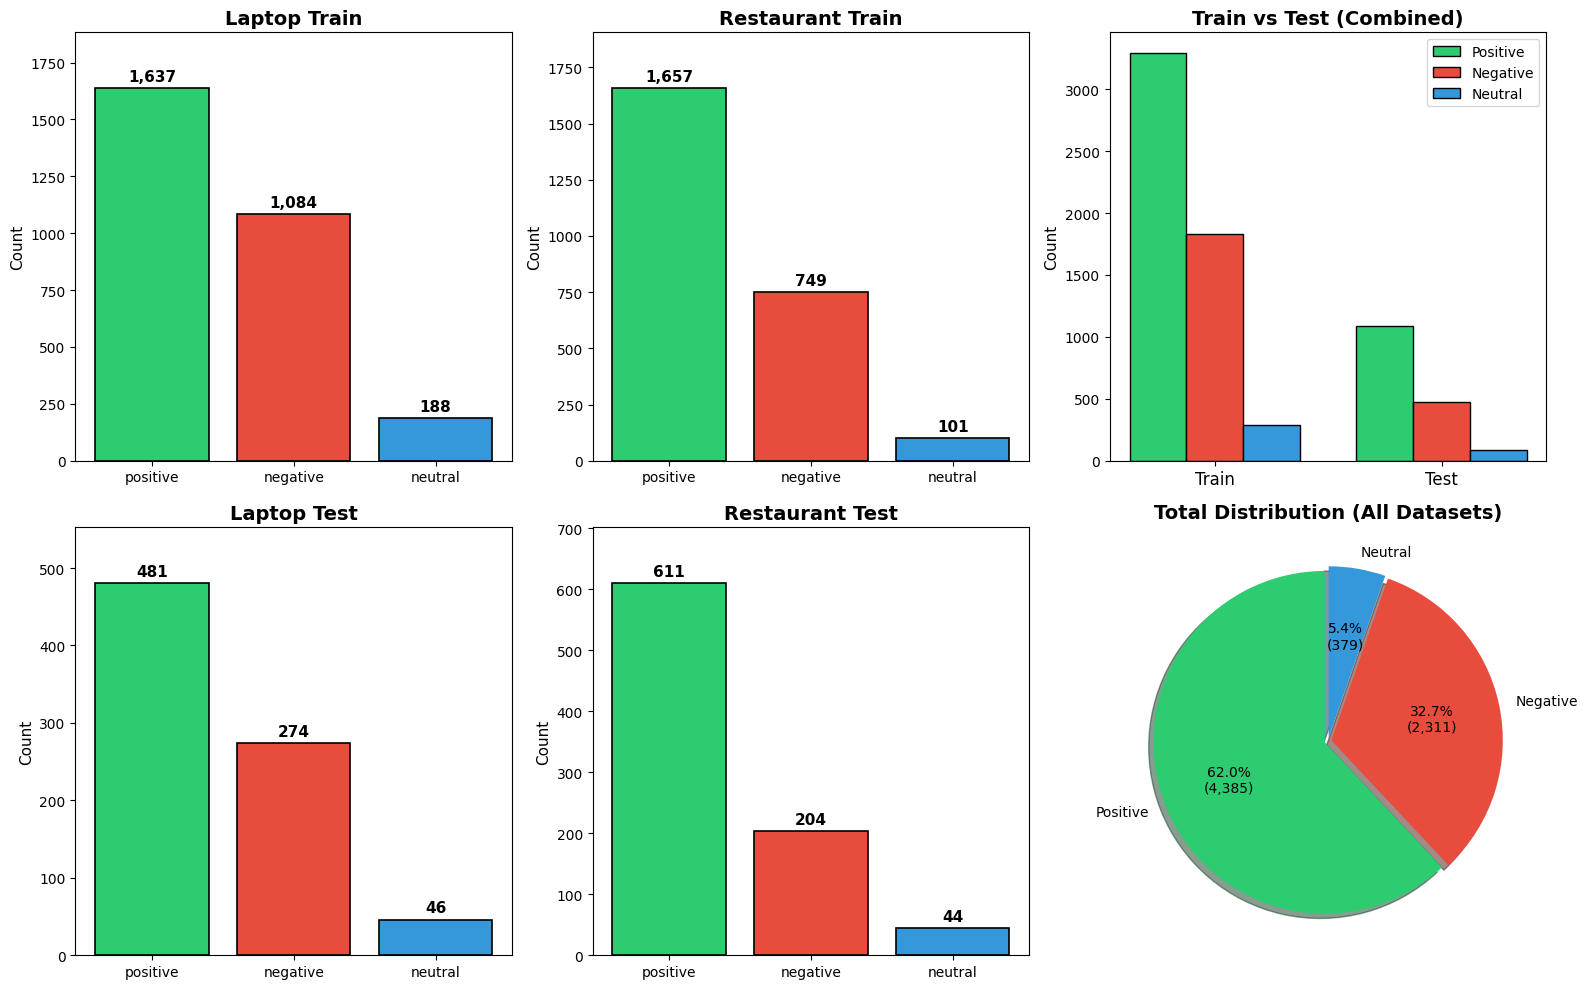

In [24]:
# ============================================
# VISUALIZE PHÂN BỐ LABEL CỦA CẢ 4 BỘ DỮ LIỆU
# ============================================
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn đến các file XML TEST
LAPTOP_TEST_XML = 'h:/SentimentAnalystSchool/MidtermExam/Semeval/Filexml/EN_LAPT_SB1_TEST_.xml'
RESTAURANT_TEST_XML = 'h:/SentimentAnalystSchool/MidtermExam/Semeval/Filexml/EN_REST_SB1_TEST.xml'

# Parse file Test
print("=" * 60)
print("PARSING TEST DATASETS")
print("=" * 60)
laptop_test_data = parse_semeval_xml(LAPTOP_TEST_XML, 'laptop')
print(f"✓ Laptop Test: {len(laptop_test_data):,} mẫu")

restaurant_test_data = parse_semeval_xml(RESTAURANT_TEST_XML, 'restaurant')
print(f"✓ Restaurant Test: {len(restaurant_test_data):,} mẫu")

# Tạo DataFrame cho Test
laptop_test_df = pd.DataFrame(laptop_test_data) if laptop_test_data else pd.DataFrame()
restaurant_test_df = pd.DataFrame(restaurant_test_data) if restaurant_test_data else pd.DataFrame()

# Đếm label cho từng bộ dữ liệu
def count_labels(df):
    if len(df) == 0:
        return {'positive': 0, 'negative': 0, 'neutral': 0}
    counts = df['polarity'].value_counts().to_dict()
    return {
        'positive': counts.get('positive', 0),
        'negative': counts.get('negative', 0),
        'neutral': counts.get('neutral', 0)
    }

# Thống kê
datasets = {
    'Laptop Train': count_labels(laptop_df),
    'Restaurant Train': count_labels(restaurant_df),
    'Laptop Test': count_labels(laptop_test_df),
    'Restaurant Test': count_labels(restaurant_test_df)
}

# In thống kê
print("\n" + "=" * 60)
print("📊 THỐNG KÊ CHI TIẾT CẢ 4 BỘ DỮ LIỆU")
print("=" * 60)
print(f"\n{'Dataset':<20} {'Positive':>10} {'Negative':>10} {'Neutral':>10} {'Total':>10}")
print("-" * 62)
for name, counts in datasets.items():
    total = sum(counts.values())
    print(f"{name:<20} {counts['positive']:>10,} {counts['negative']:>10,} {counts['neutral']:>10,} {total:>10,}")

# ============================================
# VISUALIZATION
# ============================================
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

colors = {'positive': '#2ecc71', 'negative': '#e74c3c', 'neutral': '#3498db'}
labels = ['positive', 'negative', 'neutral']

# 1. Bar chart cho từng dataset (4 subplots)
for idx, (name, counts) in enumerate(datasets.items()):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    
    values = [counts[l] for l in labels]
    bars = ax.bar(labels, values, color=[colors[l] for l in labels], edgecolor='black', linewidth=1.2)
    
    # Thêm số liệu trên cột
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.annotate(f'{val:,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_title(name, fontsize=14, fontweight='bold')
    ax.set_ylabel('Count', fontsize=11)
    ax.set_ylim(0, max(values) * 1.15 if max(values) > 0 else 10)

# 2. Stacked bar chart so sánh Train vs Test (subplot thứ 5)
ax5 = axes[0, 2]
x = np.arange(2)  # Train, Test
width = 0.25

# Tính tổng cho Train và Test
train_counts = {
    'positive': datasets['Laptop Train']['positive'] + datasets['Restaurant Train']['positive'],
    'negative': datasets['Laptop Train']['negative'] + datasets['Restaurant Train']['negative'],
    'neutral': datasets['Laptop Train']['neutral'] + datasets['Restaurant Train']['neutral']
}
test_counts = {
    'positive': datasets['Laptop Test']['positive'] + datasets['Restaurant Test']['positive'],
    'negative': datasets['Laptop Test']['negative'] + datasets['Restaurant Test']['negative'],
    'neutral': datasets['Laptop Test']['neutral'] + datasets['Restaurant Test']['neutral']
}

for i, label in enumerate(labels):
    train_val = train_counts[label]
    test_val = test_counts[label]
    ax5.bar(x + i*width, [train_val, test_val], width, label=label.capitalize(), 
            color=colors[label], edgecolor='black', linewidth=1)

ax5.set_xticks(x + width)
ax5.set_xticklabels(['Train', 'Test'], fontsize=12)
ax5.set_title('Train vs Test (Combined)', fontsize=14, fontweight='bold')
ax5.set_ylabel('Count', fontsize=11)
ax5.legend(loc='upper right')

# 3. Pie chart cho tổng phân bố (subplot thứ 6)
ax6 = axes[1, 2]
total_counts = {
    'positive': train_counts['positive'] + test_counts['positive'],
    'negative': train_counts['negative'] + test_counts['negative'],
    'neutral': train_counts['neutral'] + test_counts['neutral']
}
sizes = [total_counts[l] for l in labels]
explode = (0.02, 0.02, 0.02)

wedges, texts, autotexts = ax6.pie(sizes, explode=explode, labels=[l.capitalize() for l in labels],
                                    colors=[colors[l] for l in labels],
                                    autopct=lambda p: f'{p:.1f}%\n({int(p*sum(sizes)/100):,})',
                                    shadow=True, startangle=90,
                                    textprops={'fontsize': 10})
ax6.set_title('Total Distribution (All Datasets)', fontsize=14, fontweight='bold')

plt.tight_layout()
# plt.savefig('h:/SentimentAnalystSchool/MidtermExam/Semeval/label_distribution_visualization.png', 
#             dpi=150, bbox_inches='tight')
plt.show()

# print("\n💾 Đã lưu visualization tại: label_distribution_visualization.png")

In [25]:
# ============================================
# GỘP 2 BỘ TEST (LAPTOP + RESTAURANT)
# ============================================
print("=" * 60)
print("GỘP 2 BỘ TEST DATASET")
print("=" * 60)

# Trộn 2 bộ test
all_test_data = laptop_test_data + restaurant_test_data
df_test_merged = pd.DataFrame(all_test_data)

if len(df_test_merged) > 0:
    # Sắp xếp cột theo thứ tự chuẩn
    df_test_merged = df_test_merged[['domain', 'review_id', 'sentence_id', 'text', 'aspect', 'polarity', 'label']]
    
    print(f"📊 DataFrame Test đã tạo với {len(df_test_merged):,} dòng")
    print(f"\nCác cột: {df_test_merged.columns.tolist()}")
    
    # Thống kê theo domain
    print("\n" + "-" * 40)
    print("THỐNG KÊ THEO DOMAIN:")
    print(df_test_merged['domain'].value_counts())
    
    # Thống kê theo polarity
    print("\n" + "-" * 40)
    print("THỐNG KÊ THEO POLARITY:")
    print(df_test_merged['polarity'].value_counts())
    
    # Thống kê chi tiết
    print("\n" + "-" * 40)
    print("THỐNG KÊ CHI TIẾT THEO DOMAIN VÀ POLARITY:")
    print(pd.crosstab(df_test_merged['domain'], df_test_merged['polarity'], margins=True))
    
    # Export ra file CSV
    test_output_path = 'h:/SentimentAnalystSchool/MidtermExam/Semeval/df_test_merged_semeval.csv'
    df_test_merged.to_csv(test_output_path, index=False)
    print(f"\n✅ Đã export {len(df_test_merged):,} dòng ra file: {test_output_path}")
    
    # Hiển thị mẫu dữ liệu
    print("\n📋 Mẫu dữ liệu Test (5 dòng đầu):")
    display(df_test_merged.head())
else:
    print("⚠ Không có dữ liệu test để gộp!")

GỘP 2 BỘ TEST DATASET
📊 DataFrame Test đã tạo với 1,660 dòng

Các cột: ['domain', 'review_id', 'sentence_id', 'text', 'aspect', 'polarity', 'label']

----------------------------------------
THỐNG KÊ THEO DOMAIN:
domain
restaurant    859
laptop        801
Name: count, dtype: int64

----------------------------------------
THỐNG KÊ THEO POLARITY:
polarity
positive    1092
negative     478
neutral       90
Name: count, dtype: int64

----------------------------------------
THỐNG KÊ CHI TIẾT THEO DOMAIN VÀ POLARITY:
polarity    negative  neutral  positive   All
domain                                       
laptop           274       46       481   801
restaurant       204       44       611   859
All              478       90      1092  1660

✅ Đã export 1,660 dòng ra file: h:/SentimentAnalystSchool/MidtermExam/Semeval/df_test_merged_semeval.csv

📋 Mẫu dữ liệu Test (5 dòng đầu):


,domain,review_id,sentence_id,text,aspect,polarity,label
0,laptop,B0074703CM_108_ANONYMOUS,B0074703CM_108_ANONYMOUS:0,"Well, my first apple computer and I am impressed.",LAPTOP#GENERAL,positive,2
1,laptop,B0074703CM_108_ANONYMOUS,B0074703CM_108_ANONYMOUS:1,"Works well, fast and no reboots.",LAPTOP#OPERATION_PERFORMANCE,positive,2
2,laptop,B0074703CM_108_ANONYMOUS,B0074703CM_108_ANONYMOUS:4,Glad I did so far.,COMPANY#GENERAL,positive,2
3,laptop,B0074703CM_108_ANONYMOUS,B0074703CM_108_ANONYMOUS:4,Glad I did so far.,LAPTOP#GENERAL,positive,2
4,laptop,B00GJUQ4Z0_10_ANONYMOUS,B00GJUQ4Z0_10_ANONYMOUS:0,s.... L .... o..... w.... rea......llllyy slow.,LAPTOP#OPERATION_PERFORMANCE,negative,0


In [26]:
# Trộn 2 bộ dữ liệu và tạo DataFrame
all_data = laptop_data + restaurant_data
df_merged = pd.DataFrame(all_data)

# Sắp xếp cột theo thứ tự như df_train_all.csv
df_merged = df_merged[['domain', 'review_id', 'sentence_id', 'text', 'aspect', 'polarity', 'label']]

print(f"📊 DataFrame đã tạo với {len(df_merged):,} dòng")
print(f"\nCác cột: {df_merged.columns.tolist()}")

# Thống kê theo domain
print("\n" + "=" * 60)
print("THỐNG KÊ THEO DOMAIN")
print("=" * 60)
print(df_merged['domain'].value_counts())

# Thống kê theo polarity
print("\n" + "=" * 60)
print("THỐNG KÊ THEO POLARITY")
print("=" * 60)
print(df_merged['polarity'].value_counts())

# Thống kê theo polarity và domain
print("\n" + "=" * 60)
print("THỐNG KÊ CHI TIẾT THEO DOMAIN VÀ POLARITY")
print("=" * 60)
print(pd.crosstab(df_merged['domain'], df_merged['polarity'], margins=True))

📊 DataFrame đã tạo với 5,416 dòng

Các cột: ['domain', 'review_id', 'sentence_id', 'text', 'aspect', 'polarity', 'label']

THỐNG KÊ THEO DOMAIN
domain
laptop        2909
restaurant    2507
Name: count, dtype: int64

THỐNG KÊ THEO POLARITY
polarity
positive    3294
negative    1833
neutral      289
Name: count, dtype: int64

THỐNG KÊ CHI TIẾT THEO DOMAIN VÀ POLARITY
polarity    negative  neutral  positive   All
domain                                       
laptop          1084      188      1637  2909
restaurant       749      101      1657  2507
All             1833      289      3294  5416


In [27]:
# Xem mẫu dữ liệu
print("📋 Mẫu dữ liệu (10 dòng đầu):")
df_merged.head(10)

📋 Mẫu dữ liệu (10 dòng đầu):


,domain,review_id,sentence_id,text,aspect,polarity,label
0,laptop,79,79:1,This computer is absolutely AMAZING!!!,LAPTOP#GENERAL,positive,2
1,laptop,79,79:2,10 plus hours of battery...,BATTERY#OPERATION_PERFORMANCE,positive,2
2,laptop,79,79:3,super fast processor and really nice graphics ...,CPU#OPERATION_PERFORMANCE,positive,2
3,laptop,79,79:3,super fast processor and really nice graphics ...,GRAPHICS#GENERAL,positive,2
4,laptop,79,79:4,and plenty of storage with 250 gb(though I wil...,HARD_DISC#DESIGN_FEATURES,positive,2
5,laptop,79,79:5,This computer is really fast and I'm shocked a...,LAPTOP#OPERATION_PERFORMANCE,positive,2
6,laptop,79,79:5,This computer is really fast and I'm shocked a...,LAPTOP#USABILITY,positive,2
7,laptop,79,79:6,I've only had mine a day but I'm already used ...,LAPTOP#USABILITY,positive,2
8,laptop,79,79:8,GET THIS COMPUTER FOR PORTABILITY AND FAST PRO...,LAPTOP#PORTABILITY,positive,2
9,laptop,79,79:8,GET THIS COMPUTER FOR PORTABILITY AND FAST PRO...,CPU#OPERATION_PERFORMANCE,positive,2


In [28]:
# Export ra file CSV
output_path = 'h:/SentimentAnalystSchool/MidtermExam/Semeval/df_train_merged_semeval.csv'
df_merged.to_csv(output_path, index=False)

print(f"✅ Đã export {len(df_merged):,} dòng ra file: {output_path}")

# So sánh với file gốc df_train_all.csv
print("\n" + "=" * 60)
print("SO SÁNH VỚI FILE GỐC df_train_all.csv")
print("=" * 60)
df_original = pd.read_csv('h:/SentimentAnalystSchool/MidtermExam/Semeval/df_train_all.csv')
print(f"📊 File gốc (df_train_all.csv): {len(df_original):,} dòng")
print(f"📊 File mới (df_train_merged.csv): {len(df_merged):,} dòng")

# So sánh các cột
print(f"\nCột file gốc: {df_original.columns.tolist()}")
print(f"Cột file mới: {df_merged.columns.tolist()}")

✅ Đã export 5,416 dòng ra file: h:/SentimentAnalystSchool/MidtermExam/Semeval/df_train_merged_semeval.csv

SO SÁNH VỚI FILE GỐC df_train_all.csv
📊 File gốc (df_train_all.csv): 5,416 dòng
📊 File mới (df_train_merged.csv): 5,416 dòng

Cột file gốc: ['domain', 'review_id', 'sentence_id', 'text', 'aspect', 'polarity', 'label']
Cột file mới: ['domain', 'review_id', 'sentence_id', 'text', 'aspect', 'polarity', 'label']


In [29]:
import pandas as pd

# Đọc file gốc
df = pd.read_csv('h:/SentimentAnalystSchool/MidtermExam/Semeval/df_train_merged_semeval.csv')

print(f"Đã đọc {len(df):,} dòng dữ liệu")
print(f"\nCác cột: {df.columns.tolist()}")
print(f"\nPhân bố polarity:")
print(df['polarity'].value_counts())

Đã đọc 5,416 dòng dữ liệu

Các cột: ['domain', 'review_id', 'sentence_id', 'text', 'aspect', 'polarity', 'label']

Phân bố polarity:
polarity
positive    3294
negative    1833
neutral      289
Name: count, dtype: int64


In [30]:
# ============================================
# CẤU HÌNH SỐ LƯỢNG MẪU THEO SENTIMENT
# ============================================
# Chỉnh sửa các giá trị bên dưới để thay đổi số lượng mẫu cho mỗi nhãn
# Đặt None nếu muốn lấy tất cả dữ liệu của nhãn đó

BALANCE_CONFIG = {
    'positive': 20000,   # Số lượng mẫu positive tối đa
    'negative': 20000,   # Số lượng mẫu negative tối đa  
    'neutral': 20000     # Số lượng mẫu neutral tối đa
}

# Đặt BALANCE_CONFIG = None nếu muốn giữ tất cả dữ liệu
# BALANCE_CONFIG = None

# ============================================

# Tạo DataFrame với 2 cột: reviewText và Sentiment
df_export = pd.DataFrame({
    'reviewText': df['text'],
    'Sentiment': df['polarity'],
    'AspectTerms': df['aspect'].str.replace('#', '-', regex=False)  # Đổi # thành -
})

print(f"Tổng số mẫu ban đầu: {len(df_export):,}")
print(f"\nPhân bố Sentiment ban đầu:")
print(df_export['Sentiment'].value_counts())
print(f"\nMẫu AspectTerms sau khi đổi định dạng:")
print(df_export['AspectTerms'].head(10).tolist())

Tổng số mẫu ban đầu: 5,416

Phân bố Sentiment ban đầu:
Sentiment
positive    3294
negative    1833
neutral      289
Name: count, dtype: int64

Mẫu AspectTerms sau khi đổi định dạng:
['LAPTOP-GENERAL', 'BATTERY-OPERATION_PERFORMANCE', 'CPU-OPERATION_PERFORMANCE', 'GRAPHICS-GENERAL', 'HARD_DISC-DESIGN_FEATURES', 'LAPTOP-OPERATION_PERFORMANCE', 'LAPTOP-USABILITY', 'LAPTOP-USABILITY', 'LAPTOP-PORTABILITY', 'CPU-OPERATION_PERFORMANCE']


In [31]:
# Áp dụng cân bằng dữ liệu nếu có BALANCE_CONFIG
if BALANCE_CONFIG:
    print("=" * 60)
    print("ÁP DỤNG CÂN BẰNG DỮ LIỆU")
    print("=" * 60)
    
    balanced_dfs = []
    for sentiment, max_count in BALANCE_CONFIG.items():
        sentiment_df = df_export[df_export['Sentiment'] == sentiment]
        current_count = len(sentiment_df)
        
        if max_count is not None and current_count > max_count:
            sentiment_df = sentiment_df.sample(n=max_count, random_state=42)
            print(f"  {sentiment}: {current_count:,} → {max_count:,} (giảm {current_count - max_count:,})")
        else:
            print(f"  {sentiment}: {current_count:,} (giữ nguyên)")
        
        balanced_dfs.append(sentiment_df)
    
    df_final = pd.concat(balanced_dfs, ignore_index=True)
    # Shuffle lại
    df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)
else:
    df_final = df_export

print(f"\n📊 Tổng số mẫu sau khi xử lý: {len(df_final):,}")
print(f"\n📈 Phân bố Sentiment cuối cùng:")
print(df_final['Sentiment'].value_counts())

ÁP DỤNG CÂN BẰNG DỮ LIỆU
  positive: 3,294 (giữ nguyên)
  negative: 1,833 (giữ nguyên)
  neutral: 289 (giữ nguyên)

📊 Tổng số mẫu sau khi xử lý: 5,416

📈 Phân bố Sentiment cuối cùng:
Sentiment
positive    3294
negative    1833
neutral      289
Name: count, dtype: int64


In [32]:
# Export ra file CSV
output_path = 'h:/SentimentAnalystSchool/MidtermExam/Semeval/semeval_train.csv'
df_final.to_csv(output_path, index=False)

print(f"✓ Đã export {len(df_final):,} dòng ra file: {output_path}")
print(f"\nMẫu dữ liệu đầu tiên:")
df_final.head(10)

✓ Đã export 5,416 dòng ra file: h:/SentimentAnalystSchool/MidtermExam/Semeval/semeval_train.csv

Mẫu dữ liệu đầu tiên:


,reviewText,Sentiment,AspectTerms
0,The Macbook arrived in a nice twin packing and...,positive,LAPTOP-MISCELLANEOUS
1,We didn't look like the other patrons in there...,negative,RESTAURANT-MISCELLANEOUS
2,I read reviews that called the restaurant too ...,negative,RESTAURANT-PRICES
3,You can get a table without a reservation if y...,positive,SERVICE-GENERAL
4,I also travel with it and it never gives me an...,positive,LAPTOP-PORTABILITY
5,Glad it has the DVD drive.,positive,LAPTOP-DESIGN_FEATURES
6,I'd definitely go back again.,positive,RESTAURANT-GENERAL
7,"I love its solid build, light wt and excellent...",positive,BATTERY-OPERATION_PERFORMANCE
8,Cozy romantic atomosphere with only around 15 ...,positive,AMBIENCE-GENERAL
9,Most of the things about the laptop is awesome...,positive,LAPTOP-GENERAL


# Export df_train_all_new.csv sang định dạng chuẩn

In [1]:
# ============================================
# EXPORT df_train_all_new.csv SANG ĐỊNH DẠNG CHUẨN
# ============================================
import pandas as pd

# Đọc file gốc
df_new = pd.read_csv('h:/SentimentAnalystSchool/MidtermExam/Semeval/df_train_all_new.csv')

print(f"Đã đọc {len(df_new):,} dòng dữ liệu")
print(f"\nCác cột gốc: {df_new.columns.tolist()}")
print(f"\nPhân bố polarity:")
print(df_new['polarity'].value_counts())

# Tạo DataFrame với định dạng chuẩn: reviewText, AspectTerm, Sentiment
df_export_new = pd.DataFrame({
    'reviewText': df_new['text'],
    'AspectTerm': df_new['aspect'].str.replace('#', '-', regex=False),  # Đổi # thành -
    'Sentiment': df_new['polarity']
})

print(f"\n📊 DataFrame mới với {len(df_export_new):,} dòng")
print(f"Các cột mới: {df_export_new.columns.tolist()}")
print(f"\nMẫu AspectTerm sau khi đổi định dạng:")
print(df_export_new['AspectTerm'].head(10).tolist())

Đã đọc 5,705 dòng dữ liệu

Các cột gốc: ['domain', 'review_id', 'sentence_id', 'text', 'aspect', 'polarity', 'label']

Phân bố polarity:
polarity
positive    3294
negative    1833
neutral      578
Name: count, dtype: int64

📊 DataFrame mới với 5,705 dòng
Các cột mới: ['reviewText', 'AspectTerm', 'Sentiment']

Mẫu AspectTerm sau khi đổi định dạng:
['DISPLAY-USABILITY', 'DISPLAY-DESIGN_FEATURES', 'BATTERY-OPERATION_PERFORMANCE', 'OS-USABILITY', 'LAPTOP-PRICE', 'LAPTOP-DESIGN_FEATURES', 'SUPPORT-QUALITY', 'LAPTOP-USABILITY', 'LAPTOP-QUALITY', 'LAPTOP-PRICE']


In [2]:
# Export ra file CSV với định dạng chuẩn
output_path_new = 'h:/SentimentAnalystSchool/MidtermExam/Semeval/semeval_train_new.csv'
df_export_new.to_csv(output_path_new, index=False)

print(f"✅ Đã export {len(df_export_new):,} dòng ra file: {output_path_new}")
print(f"\n📈 Phân bố Sentiment:")
print(df_export_new['Sentiment'].value_counts())
print(f"\n📋 Mẫu dữ liệu (10 dòng đầu):")
df_export_new.head(10)

✅ Đã export 5,705 dòng ra file: h:/SentimentAnalystSchool/MidtermExam/Semeval/semeval_train_new.csv

📈 Phân bố Sentiment:
Sentiment
positive    3294
negative    1833
neutral      578
Name: count, dtype: int64

📋 Mẫu dữ liệu (10 dòng đầu):


,reviewText,AspectTerm,Sentiment
0,The laptop's screen is much larger than the sc...,DISPLAY-USABILITY,neutral
1,"The screen's reduced size, which is smaller th...",DISPLAY-DESIGN_FEATURES,neutral
2,The battery's limited lifespan makes it unlike...,BATTERY-OPERATION_PERFORMANCE,neutral
3,"I've been using a Mac for my entire life, even...",OS-USABILITY,neutral
4,I purchased a laptop for about $100 plus a few...,LAPTOP-PRICE,neutral
5,The laptop's portability was not a major issue...,LAPTOP-DESIGN_FEATURES,neutral
6,"Dell's customer service was unsatisfactory, an...",SUPPORT-QUALITY,neutral
7,Currently learning how to operate it.,LAPTOP-USABILITY,neutral
8,"The temperature is a slight concern, but it is...",LAPTOP-QUALITY,neutral
9,"Despite the price tag, this is a win-win situa...",LAPTOP-PRICE,neutral


# Test Semeval export csv

In [33]:
import pandas as pd

# Đọc file gốc
df = pd.read_csv('h:/SentimentAnalystSchool/MidtermExam/Semeval/df_test_merged_semeval.csv')

print(f"Đã đọc {len(df):,} dòng dữ liệu")
print(f"\nCác cột: {df.columns.tolist()}")
print(f"\nPhân bố polarity:")
print(df['polarity'].value_counts())

Đã đọc 1,660 dòng dữ liệu

Các cột: ['domain', 'review_id', 'sentence_id', 'text', 'aspect', 'polarity', 'label']

Phân bố polarity:
polarity
positive    1092
negative     478
neutral       90
Name: count, dtype: int64


In [34]:
# ============================================
# CẤU HÌNH SỐ LƯỢNG MẪU THEO SENTIMENT
# ============================================
# Chỉnh sửa các giá trị bên dưới để thay đổi số lượng mẫu cho mỗi nhãn
# Đặt None nếu muốn lấy tất cả dữ liệu của nhãn đó

BALANCE_CONFIG = {
    'positive': 20000,   # Số lượng mẫu positive tối đa
    'negative': 20000,   # Số lượng mẫu negative tối đa  
    'neutral': 20000     # Số lượng mẫu neutral tối đa
}

# Đặt BALANCE_CONFIG = None nếu muốn giữ tất cả dữ liệu
# BALANCE_CONFIG = None

# ============================================

# Tạo DataFrame với 2 cột: reviewText và Sentiment
df_export = pd.DataFrame({
    'reviewText': df['text'],
    'Sentiment': df['polarity'],
    'AspectTerms': df['aspect'].str.replace('#', '-', regex=False)  # Đổi # thành -
})

print(f"Tổng số mẫu ban đầu: {len(df_export):,}")
print(f"\nPhân bố Sentiment ban đầu:")
print(df_export['Sentiment'].value_counts())
print(f"\nMẫu AspectTerms sau khi đổi định dạng:")
print(df_export['AspectTerms'].head(10).tolist())

Tổng số mẫu ban đầu: 1,660

Phân bố Sentiment ban đầu:
Sentiment
positive    1092
negative     478
neutral       90
Name: count, dtype: int64

Mẫu AspectTerms sau khi đổi định dạng:
['LAPTOP-GENERAL', 'LAPTOP-OPERATION_PERFORMANCE', 'COMPANY-GENERAL', 'LAPTOP-GENERAL', 'LAPTOP-OPERATION_PERFORMANCE', 'LAPTOP-OPERATION_PERFORMANCE', 'LAPTOP-USABILITY', 'LAPTOP-USABILITY', 'LAPTOP-MISCELLANEOUS', 'LAPTOP-GENERAL']


In [35]:
# Áp dụng cân bằng dữ liệu nếu có BALANCE_CONFIG
if BALANCE_CONFIG:
    print("=" * 60)
    print("ÁP DỤNG CÂN BẰNG DỮ LIỆU")
    print("=" * 60)
    
    balanced_dfs = []
    for sentiment, max_count in BALANCE_CONFIG.items():
        sentiment_df = df_export[df_export['Sentiment'] == sentiment]
        current_count = len(sentiment_df)
        
        if max_count is not None and current_count > max_count:
            sentiment_df = sentiment_df.sample(n=max_count, random_state=42)
            print(f"  {sentiment}: {current_count:,} → {max_count:,} (giảm {current_count - max_count:,})")
        else:
            print(f"  {sentiment}: {current_count:,} (giữ nguyên)")
        
        balanced_dfs.append(sentiment_df)
    
    df_final = pd.concat(balanced_dfs, ignore_index=True)
    # Shuffle lại
    df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)
else:
    df_final = df_export

print(f"\n📊 Tổng số mẫu sau khi xử lý: {len(df_final):,}")
print(f"\n📈 Phân bố Sentiment cuối cùng:")
print(df_final['Sentiment'].value_counts())

ÁP DỤNG CÂN BẰNG DỮ LIỆU
  positive: 1,092 (giữ nguyên)
  negative: 478 (giữ nguyên)
  neutral: 90 (giữ nguyên)

📊 Tổng số mẫu sau khi xử lý: 1,660

📈 Phân bố Sentiment cuối cùng:
Sentiment
positive    1092
negative     478
neutral       90
Name: count, dtype: int64


In [36]:
# Export ra file CSV
output_path = 'h:/SentimentAnalystSchool/MidtermExam/Semeval/semeval_test.csv'
df_final.to_csv(output_path, index=False)

print(f"✓ Đã export {len(df_final):,} dòng ra file: {output_path}")
print(f"\nMẫu dữ liệu đầu tiên:")
df_final.head(10)

✓ Đã export 1,660 dòng ra file: h:/SentimentAnalystSchool/MidtermExam/Semeval/semeval_test.csv

Mẫu dữ liệu đầu tiên:


,reviewText,Sentiment,AspectTerms
0,It's a tiny place so if you get there before 8...,neutral,RESTAURANT-MISCELLANEOUS
1,"Overall, it is a fantastic laptop.",positive,LAPTOP-GENERAL
2,Once in a long while that doesn't work; in tha...,neutral,LAPTOP-USABILITY
3,The touchpad is a little &quot;clunky&quot; fo...,negative,MOUSE-DESIGN_FEATURES
4,Only 2 USB ports.,negative,LAPTOP-DESIGN_FEATURES
5,No more Apple devices in my household.,negative,COMPANY-GENERAL
6,If I want to stand in line on Sunday for an ho...,neutral,FOOD-QUALITY
7,You Can't Go Wrong Here.,positive,RESTAURANT-GENERAL
8,Very great Apple product as expected.,positive,LAPTOP-GENERAL
9,Drinks were good.,positive,DRINKS-QUALITY


## Benchmark với Model DistilBERT + LSTM

Sử dụng model đã train để benchmark trên bộ dữ liệu Semeval

In [ ]:
# Import các thư viện cần thiết cho benchmark
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Kiểm tra GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [ ]:
# Định nghĩa Model Architecture (phải giống với model đã train)
class DistilBertLSTMClassifier(nn.Module):
    def __init__(self, n_classes=3, lstm_hidden_size=128, lstm_layers=2, dropout=0.3):
        super(DistilBertLSTMClassifier, self).__init__()
        
        # DistilBERT
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0,
            bidirectional=True
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Classifier
        self.fc = nn.Linear(lstm_hidden_size * 2, n_classes)
        
    def forward(self, input_ids, attention_mask):
        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        sequence_output = distilbert_output.last_hidden_state
        lstm_output, (hidden, cell) = self.lstm(sequence_output)
        hidden_fwd = hidden[-2, :, :]
        hidden_bwd = hidden[-1, :, :]
        hidden_concat = torch.cat((hidden_fwd, hidden_bwd), dim=1)
        hidden_concat = self.dropout(hidden_concat)
        output = self.fc(hidden_concat)
        return output

print("✓ Model architecture defined")

In [ ]:
# Dataset class cho benchmark
class BenchmarkDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = str(self.data.loc[idx, 'text'])
        aspect = str(self.data.loc[idx, 'aspect'])
        label = self.data.loc[idx, 'label']
        
        # Kết hợp text và aspect
        combined_text = text + " [SEP] " + aspect
        
        encoding = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

print("✓ Dataset class defined")

In [ ]:
# Load model weights
MODEL_PATH = 'h:/SentimentAnalystSchool/MidtermExam/ModelWeight/distilbert_lstm_model_complete.pt'

# Load checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)

# Khởi tạo model
model = DistilBertLSTMClassifier(n_classes=3)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

# Load label encoder từ checkpoint
label_encoder = checkpoint['label_encoder']
MAX_LEN = checkpoint.get('max_len', 128)

print("✓ Model loaded successfully")
print(f"Label classes: {label_encoder.classes_}")

In [ ]:
# Load và chuẩn bị dữ liệu benchmark
df_benchmark = pd.read_csv('h:/SentimentAnalystSchool/MidtermExam/Semeval/df_train_all.csv')

print(f"Loaded {len(df_benchmark):,} samples for benchmark")
print(f"\nPolarity distribution:")
print(df_benchmark['polarity'].value_counts())

# Encode labels (sử dụng label encoder từ model)
# Map polarity sang label number
polarity_to_label = {label: idx for idx, label in enumerate(label_encoder.classes_)}
df_benchmark['label'] = df_benchmark['polarity'].map(polarity_to_label)

# Kiểm tra xem có giá trị nào không map được không
missing_labels = df_benchmark['label'].isna().sum()
if missing_labels > 0:
    print(f"\n⚠ Warning: {missing_labels} samples có polarity không khớp với label encoder")
    print(f"Polarity trong data: {df_benchmark['polarity'].unique()}")
    print(f"Labels trong model: {label_encoder.classes_}")

# Bỏ các dòng không map được
df_benchmark = df_benchmark.dropna(subset=['label'])
df_benchmark['label'] = df_benchmark['label'].astype(int)

print(f"\nSamples sau khi xử lý: {len(df_benchmark):,}")

In [ ]:
# Tạo DataLoader cho benchmark
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
BATCH_SIZE = 16

benchmark_dataset = BenchmarkDataset(df_benchmark, tokenizer, MAX_LEN)
benchmark_loader = DataLoader(benchmark_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✓ DataLoader created with {len(benchmark_loader)} batches")

In [ ]:
# Hàm benchmark
def run_benchmark(model, data_loader, device):
    """
    Chạy benchmark trên bộ dữ liệu
    
    Returns:
        accuracy, all_preds, all_labels
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    print("=" * 60)
    print("RUNNING BENCHMARK")
    print("=" * 60)
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            if (batch_idx + 1) % 50 == 0:
                print(f"  Processed {batch_idx + 1}/{len(data_loader)} batches...")
    
    accuracy = accuracy_score(all_labels, all_preds)
    
    return accuracy, all_preds, all_labels

print("✓ Benchmark function defined")

In [ ]:
# Chạy benchmark
import time

start_time = time.time()
accuracy, all_preds, all_labels = run_benchmark(model, benchmark_loader, device)
elapsed_time = time.time() - start_time

print(f"\n" + "=" * 60)
print("BENCHMARK RESULTS")
print("=" * 60)
print(f"\n⏱ Time: {elapsed_time:.2f} seconds")
print(f"📊 Total samples: {len(all_labels):,}")
print(f"🎯 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

In [ ]:
# Chi tiết classification report
from sklearn.metrics import classification_report

label_names = ['Negative', 'Neutral', 'Positive']
report = classification_report(all_labels, all_preds, target_names=label_names)
print("📋 Classification Report:")
print("-" * 60)
print(report)

In [ ]:
# Confusion Matrix Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Tạo confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Confusion Matrix với số lượng
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# 2. Confusion Matrix với phần trăm (normalized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names, ax=axes[1])
axes[1].set_title('Confusion Matrix (Percentage %)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('benchmark_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Confusion matrix saved to 'benchmark_confusion_matrix.png'")

In [ ]:
# Thống kê chi tiết theo từng class
print("📊 Detailed Statistics per Class:")
print("-" * 60)

for i, label in enumerate(label_names):
    total = cm[i].sum()
    correct = cm[i][i]
    incorrect = total - correct
    class_acc = (correct / total * 100) if total > 0 else 0
    
    print(f"\n{label.upper()}:")
    print(f"  • Total samples: {total:,}")
    print(f"  • Correct predictions: {correct:,} ({class_acc:.1f}%)")
    print(f"  • Incorrect predictions: {incorrect:,} ({100-class_acc:.1f}%)")

# Summary
print("\n" + "=" * 60)
print("📈 OVERALL SUMMARY:")
print(f"  • Dataset: Semeval (df_train_all.csv)")
print(f"  • Model: DistilBERT + LSTM")
print(f"  • Weight file: distilbert_lstm_model_complete.pt")
print(f"  • Overall Accuracy: {accuracy*100:.2f}%")
print("=" * 60)